In [101]:
%matplotlib inline

In [102]:
import os.path

from matplotlib import ticker
import matplotlib.pyplot as plt
from nengo.dists import CosineSimilarity
import numpy as np
from scipy.optimize import fsolve
from scipy.special import beta, gamma
from scipy import integrate

In [103]:
textwidth = 390.56151 / 72.27
row_height = textwidth / 1.5 / 1.6
single_fig_size = (textwidth / 1.5, row_height)


def save_tight_fig(fig, path, pad_inches=0., **kwargs):
    dirname = os.path.dirname(path)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    fig.savefig(path, bbox_inches='tight', pad_inches=pad_inches, **kwargs)


weight = 'light'
sns.set('paper', 'ticks', None, rc={
    'axes.labelweight': weight,
    'axes.linewidth': 0.6,
    'axes.titleweight': weight,
    'font.cursive': ['cmsy10'],
    'font.sans-serif': ['Lato'],
    'font.weight': weight,
    'lines.linewidth': 1.,
    'lines.markersize': 4,
    'mathtext.fontset': 'custom',
})

In [114]:
cc_sim = {
    2: 0.5579481179146595,
    3: 0.29241144039321426,
    4: 0.11418067597602344,
    5: 0.033746530261135436,
    6: -0.006885981292808013,
    7: -0.0216477933456276,
}

vtb_sim = {
    2: 0.555179340605646,
    3: 0.37701993583903615,
    4: 0.2749751969505107,
    5: 0.2159885216534928,
    6: 0.17566487134716197,
    7: 0.14305184430252316,
}

In [115]:
def packing_lower_bound(max_sim, d):
    d = np.asfarray(d)
    k = d / (d - 1) * beta((d + 1) / 2., 0.5)
    q = np.vectorize(lambda max_sim_, d_: integrate.quad(lambda x: np.sin(x)**(d_ - 2), 0., np.arccos(max_sim_))[0])(
        max_sim, d)
    return np.maximum(d, k / q)

def packing_upper_bound(max_sim, d):
    psi = np.arcsin(np.sqrt(2.) * np.sin(np.arccos(max_sim) / 2))
    n = beta((d - 1) / 2., 0.5) * np.sin(psi) * np.tan(psi)
    q = np.vectorize(lambda max_sim_, d_, psi_: integrate.quad(
        lambda x: np.sin(x)**(d_ - 2) * (np.cos(x) - np.cos(psi_)), 0., psi_)[0])(
        max_sim, d, psi)
    dn = 2 * q
    return n / dn

In [116]:
max_sims = np.linspace(0.01, 0.3)
ds = np.arange(2, 64)**2
x, y = np.meshgrid(max_sims, ds)
z = packing_lower_bound(x, y)

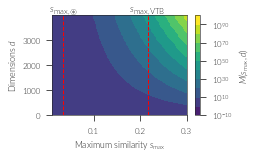

In [117]:
fig = plt.figure(figsize=single_fig_size)
ax = fig.add_subplot(1, 1, 1)

cf = ax.contourf(x, y, z, locator=ticker.LogLocator(), cmap='viridis')
cbar = fig.colorbar(cf)
ax.axvline(x=cc_sim[5], c='red', linestyle='--')
ax.axvline(x=vtb_sim[5], c='red', linestyle='--')

ax.set_xlabel(r"Maximum similarity $s_{\mathrm{max}}$")
ax.set_ylabel("Dimensions $d$")
cbar.set_label(r"$M(s_{\mathrm{max}}, d)$")

import matplotlib
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amssymb}',
    r'\usepackage[default]{lato}',
    r'\renewcommand{\mddefault}{l}',
    r'\usepackage{mathastext}',
]
ax.text(
    cc_sim[5], np.max(ds), r"$\mathit{s}_{max,\circledast}$",
    horizontalalignment='center', verticalalignment='bottom', usetex=True)
ax.text(
    vtb_sim[5], np.max(ds), r"$\mathit{s}_{max,VTB}$",
    horizontalalignment='center', verticalalignment='bottom', usetex=True)

fig.tight_layout()

In [118]:
save_tight_fig(fig, '../../vtb-paper/figures/vocabsize.pdf', pad_inches=0.02)

/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/home/jgosmann/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/mathtext.py:834: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


4
intersection 1675.260526228084
CC d 837.630263114042
VTB d 141.05491934924933
4
intersection 1157.4399431684722
CC d 578.7199715842361
VTB d 110.238250046833
5
intersection 3270.8552176192334
CC d 1635.4276088096167
VTB d 220.3472055691731
5
intersection 8.000000000000012
CC d 4.000000000000006
VTB d 4.0000000000000036


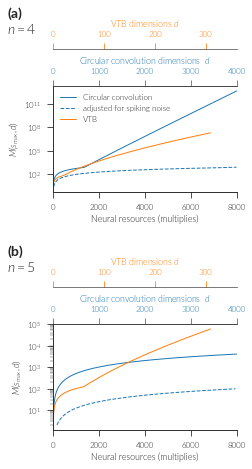

In [121]:
fig = plt.figure(figsize=(textwidth / 1.5, 2 * 1.5 * row_height))

for i, name in zip(range(4, 6), ['a', 'b']):
    ax = fig.add_subplot(2, 1, i - 3)
    
    noise_scaling = (vtb_sim[i] / cc_sim[i])**2.

    cc_ds = np.arange(2, 4000)
    cc_multiplies = 2 * cc_ds
    ax.plot(cc_multiplies, packing_lower_bound(cc_sim[i], cc_ds), label="Circular convolution")

    cc_scaled_ds = np.arange(2, np.max(cc_multiplies) / 2. / noise_scaling)
    cc_scaled_multiplies = 2 * cc_scaled_ds * noise_scaling
    ax.plot(
        cc_scaled_multiplies, packing_lower_bound(cc_sim[i], cc_scaled_ds),
        c='C0', ls='--', label="adjusted for spiking noise")

    vtb_ds = np.arange(2, np.sqrt(np.max(cc_multiplies)**(2./3.)))**2.
    vtb_multiplies = vtb_ds**1.5
    ax.plot(vtb_multiplies, packing_lower_bound(vtb_sim[i], vtb_ds), label="VTB")

    ax.set_xlim(0., np.max(cc_multiplies))
    cc_d_scale = ax.twiny()
    cc_d_scale.set_xlim(0., np.max(cc_ds))
    vtb_d_scale = ax.twiny()
    vtb_d_scale.set_xlim(0., np.max(vtb_ds))

    vtb_d_scale.spines['top'].set_position(('axes', 1.35))

    cc_d_scale.xaxis.label.set_color('C0')
    vtb_d_scale.xaxis.label.set_color('C1')
    cc_d_scale.tick_params(axis='x', colors='C0')
    vtb_d_scale.tick_params(axis='x', colors='C1')

    ax.set_xlabel("Neural resources (multiplies)")
    ax.set_ylabel(r"$M(s_{\mathrm{max}}, d)$")
    cc_d_scale.set_xlabel("Circular convolution dimensions  $d$")
    vtb_d_scale.set_xlabel("VTB dimensions $d$")

    if i < 5:
        ax.legend(loc='best')
    ax.semilogy()
    ax.text(-0.25, 1.5, "({})\n$n = {}$".format(name, i), transform=ax.transAxes, weight='bold', fontsize=14)
    
    intersection = fsolve(
        lambda x: packing_lower_bound(cc_sim[i], x / 2.) - packing_lower_bound(vtb_sim[i], x**(2./3.)), 3000)[0]
    print(i)
    print("intersection", intersection)
    print("CC d", intersection / 2.)
    print("VTB d", intersection**(2./3.))
    
    intersection = fsolve(
        lambda x: packing_lower_bound(cc_sim[i], x / 2.) - packing_lower_bound(vtb_sim[i], x**(2./3.)), 1000)[0]
    print(i)
    print("intersection", intersection)
    print("CC d", intersection / 2.)
    print("VTB d", intersection**(2./3.))

sns.despine(fig, top=False)
fig.tight_layout(rect=(0., 0., 1., 1.))

In [122]:
save_tight_fig(fig, '../../vtb-paper/figures/tradeoff4.pdf')